# IE 582 Homework 2 - FALL'24

#### Berat Kubilay Güngez - 2021402087

### Table of Contents

1. [Introduction](#introduction)
2. [Library and Data Imports](#import)
3. [Implied Probability Calculation and Analysis](#prob)
4. [Noisy Data Analysis](#noisy)
5. [Decision Tree Model](#tree)
6. [Conclusion](#conclusion)
7. [Code](#code)

### Introduction <a name="introduction"></a>

This homework assignment explores the application of statistical and basic machine learning techniques in the context of sports betting, with a particular focus on predicting football match outcomes. The primary objective is to assess the relationship between betting odds, implied probabilities, and actual match results by using a decision tree model for prediction. The project involves calculating implied probabilities from betting odds, cleaning the data by removing events create noise, and comparing the implied probabilities to the results generated by the decision tree model.

### Library and Data Imports <a name="import"></a>

In [647]:
import pandas as pd # data importing and manipulation 
import matplotlib.pyplot as plt # data visualization
import numpy as np # linear algebra and math functions
from sklearn.tree import DecisionTreeClassifier, plot_tree # decision tree classifier
from sklearn.metrics import accuracy_score # accuracy score

The first step in the analysis is importing the data from the provided CSV file. Any missing values (NaN) in the dataset are replaced with zeros. Given the size of the dataset, this approach is considered appropriate, as it ensures that the model can handle the data without issues related to missing values, and the impact of replacing NaN values with zeros is minimal in this context.

In [648]:
data_loc = "match data/data"
df = pd.read_csv(data_loc)
df.fillna(0, inplace=True) # fill NaN values with 0

df.head(10)

,fixture_id,halftime,current_time,half_start_datetime,match_start_datetime,minute,second,latest_bookmaker_update,suspended,stopped,...,Throwins - home,Total Crosses - away,Total Crosses - home,Yellowcards - away,Yellowcards - home,Yellowred Cards - away,Yellowred Cards - home,current_state,final_score,result
0,19172016.0,1st-half,2024-08-09 18:11:36,2024-08-09 18:01:37,2024-08-09 18:01:37,9,59,2024-08-09 18:11:28,False,False,...,1.0,0.0,3.0,0.0,0.0,0.0,0.0,X,2-1,1
1,19172016.0,1st-half,2024-08-09 18:27:30,2024-08-09 18:01:37,2024-08-09 18:01:37,25,53,2024-08-09 18:27:24,False,False,...,11.0,1.0,12.0,0.0,0.0,0.0,0.0,X,2-1,1
2,19172016.0,1st-half,2024-08-09 18:28:25,2024-08-09 18:01:37,2024-08-09 18:01:37,26,48,2024-08-09 18:28:20,False,False,...,11.0,1.0,13.0,0.0,0.0,0.0,0.0,X,2-1,1
3,19172016.0,1st-half,2024-08-09 18:29:32,2024-08-09 18:01:37,2024-08-09 18:01:37,27,55,2024-08-09 18:29:28,False,False,...,11.0,1.0,13.0,0.0,0.0,0.0,0.0,X,2-1,1
4,19172016.0,1st-half,2024-08-09 18:30:37,2024-08-09 18:01:37,2024-08-09 18:01:37,29,0,2024-08-09 18:30:32,True,False,...,11.0,1.0,14.0,0.0,0.0,0.0,0.0,X,2-1,1
5,19172016.0,1st-half,2024-08-09 18:31:18,2024-08-09 18:01:37,2024-08-09 18:01:37,29,41,2024-08-09 18:31:17,True,False,...,11.0,1.0,14.0,0.0,0.0,0.0,0.0,X,2-1,1
6,19172016.0,1st-half,2024-08-09 18:32:24,2024-08-09 18:01:37,2024-08-09 18:01:37,30,47,2024-08-09 18:32:22,True,False,...,11.0,1.0,14.0,0.0,0.0,0.0,0.0,X,2-1,1
7,19172016.0,1st-half,2024-08-09 18:33:27,2024-08-09 18:01:37,2024-08-09 18:01:37,31,50,2024-08-09 18:33:21,True,False,...,11.0,1.0,14.0,0.0,0.0,0.0,0.0,X,2-1,1
8,19172016.0,1st-half,2024-08-09 18:34:18,2024-08-09 18:01:37,2024-08-09 18:01:37,32,41,2024-08-09 18:34:12,False,False,...,11.0,1.0,14.0,0.0,0.0,0.0,0.0,X,2-1,1
9,19172016.0,1st-half,2024-08-09 18:35:27,2024-08-09 18:01:37,2024-08-09 18:01:37,33,50,2024-08-09 18:35:26,False,False,...,11.0,1.0,15.0,0.0,0.0,0.0,0.0,X,2-1,1


Suspended and stopped matches are dropped from the dataset, as they do not provide meaningful information for the analysis. This was given in the homework description. In total, approx. 12% of the data is dropped due to this reason.

In [649]:
print(f"Before suspended or stopped games are dropped: {len(df)}")

columns_to_check = [
    "suspended",
    "stopped"]

mask = (df[columns_to_check] == False).all(axis=1) # mask for rows where all columns are False

df = df[mask] 
print(f"After suspended or stopped games are dropped: {len(df)}")

Before suspended or stopped games are dropped: 63944
After suspended or stopped games are dropped: 56127


### Implied Probability Calculation and Analysis <a name="prob"></a>

In the sports betting context;
- "1" represents the amount of money that can be won by betting 1 unit on the home team
- "X" represents the amount of money that can be won by betting 1 unit on a draw
- "2" represents the amount of money that can be won by betting 1 unit on the away team

In [650]:
df_odds = df.copy()

results = df_odds['result'] # save the results column
half = df_odds['halftime'] # save the halftime column
df_odds = df_odds.loc[:, "1":"X"]

df_odds.head()

,1,2,X
0,1.22,10.0,6.5
1,1.20,13.0,6.0
2,1.20,13.0,6.0
3,1.20,13.0,6.0
8,1.20,15.0,6.0


The implied probability of an event is calculated as the inverse of the odds for that event. For example, if the odds for the home team winning are 2.0, the implied probability is 1/2.0 = 0.5. This calculation is performed for all events in the dataset to determine the implied probabilities for each outcome. Also, note that these probabilities sum up more than 1, which is expected as bookmakers add a margin to the odds to ensure profitability. Therefore, the implied probabilities are normalized to sum up to 1.

In [651]:
prob_df = 1 / df_odds # calculate the probability of each outcome
prob_df.columns = ["Pr{Home Win}", "Pr{Away Win}", "Pr{Draw}"]

normalized_prob_df = prob_df.div(prob_df.sum(axis=1), axis=0) # normalize the probabilities

prob_df["Result"] = results
prob_df["Half"] = half
normalized_prob_df["Result"] = results
normalized_prob_df["Half"] = half

prob_df.head()

,Pr{Home Win},Pr{Away Win},Pr{Draw},Result,Half
0,0.819672,0.100000,0.153846,1,1st-half
1,0.833333,0.076923,0.166667,1,1st-half
2,0.833333,0.076923,0.166667,1,1st-half
3,0.833333,0.076923,0.166667,1,1st-half
8,0.833333,0.066667,0.166667,1,1st-half


In [652]:
prob_df.iloc[np.random.randint(0, len(prob_df))][["Pr{Home Win}", "Pr{Away Win}", "Pr{Draw}"]].sum() # to demonstrate that the probabilities sum to more than 1

1.0634920634920635

In [653]:
normalized_prob_df.head()

,Pr{Home Win},Pr{Away Win},Pr{Draw},Result,Half
0,0.763538,0.093152,0.143310,1,1st-half
1,0.773810,0.071429,0.154762,1,1st-half
2,0.773810,0.071429,0.154762,1,1st-half
3,0.773810,0.071429,0.154762,1,1st-half
8,0.781250,0.062500,0.156250,1,1st-half


In [654]:
normalized_prob_df.iloc[np.random.randint(0, len(normalized_prob_df))][["Pr{Home Win}", "Pr{Away Win}", "Pr{Draw}"]].sum() # to demonstrate that the normalized probabilities sum to 1

1.0

Next, let us inspect the normalized and non-normalized implied probabilities in a comparative manner. To achieve this, the data is split into two groups based on the half of the game being played. For each instance, the difference between the home win probabilities and away win probabilities is calculated. Differences are splitted into 8 bins. Subsequently, the average number of games that ended in a draw is computed for each bin.

The results of this analysis are as follows:

In [655]:
bins = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1] # define the bins for the histogram

prob_df["Pr{Home Win} - Pr{Away Win}"] = prob_df["Pr{Home Win}"] - prob_df["Pr{Away Win}"] 
prob_df["Bin"] = pd.cut(prob_df["Pr{Home Win} - Pr{Away Win}"], bins) # split the data into bins

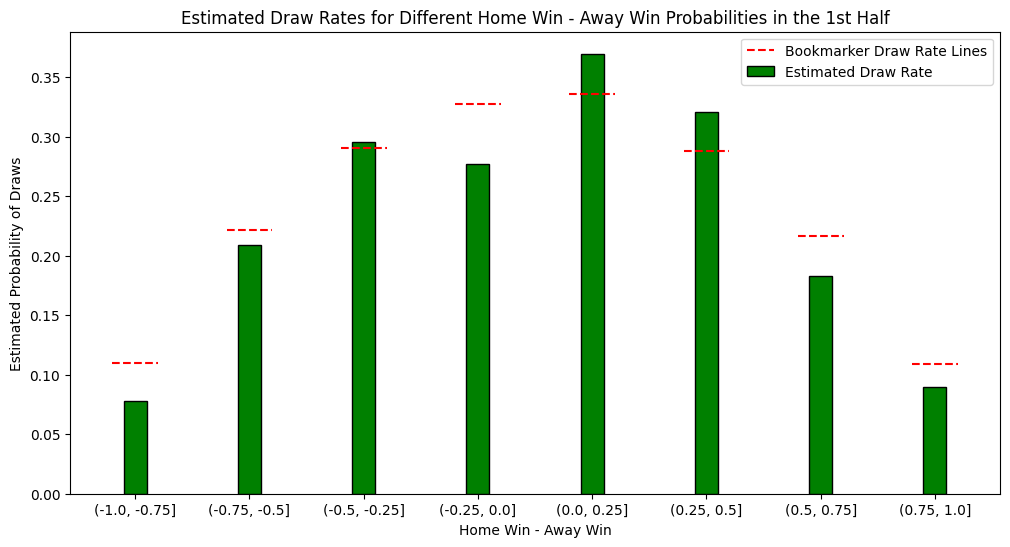

In [656]:
first_half_prob_df = prob_df[prob_df["Half"] == "1st-half"] # filter the data for the first half

bin_totals = first_half_prob_df.groupby("Bin", observed=False).size() # calculate the total number of games in each bin
bin_draws = first_half_prob_df[first_half_prob_df["Result"] == "X"].groupby("Bin", observed=False).size() # calculate the number of draws in each bin

estimated_draws = bin_draws / bin_totals # calculate the estimated draw probabilities for each bin

bookmarker_draws = first_half_prob_df.groupby("Bin", observed=False)["Pr{Draw}"].mean() # calculate the average bookmarker draw probabilities for each bin

plt.figure(figsize=(12, 6))

plt.bar(bin_totals.index.astype(str), estimated_draws , width=0.2, align="center", edgecolor = "black", color = "green", label="Estimated Draw Rate")
plt.hlines(
    y=bookmarker_draws,                  
    xmin=-0.2 + np.arange(len(bookmarker_draws)),  
    xmax=0.2 + np.arange(len(bookmarker_draws)),  
    colors="red",
    linestyles="--",
    label="Bookmarker Draw Rate Lines")

plt.legend(loc="upper right")
plt.xlabel("Home Win - Away Win")
plt.ylabel("Estimated Probability of Draws")
plt.title("Estimated Draw Rates for Different Home Win - Away Win Probabilities in the 1st Half")

plt.show()

As observed above, with the exception of the (-0.5, -0.25] bin, the number of games that ended in a draw deviates significantly from the bookmakers' implied probabilities. This observation suggests that the bookmakers' odds are not perfectly calibrated, as the implied probabilities fail to align with the actual match outcomes. Three of the most obvious reasons are the bookmakers' profit margin, the presence of noise in the data, and the data being from the first half of the game. We should expect second half data to be more accurate since the second half of the game is more closer to the final result.

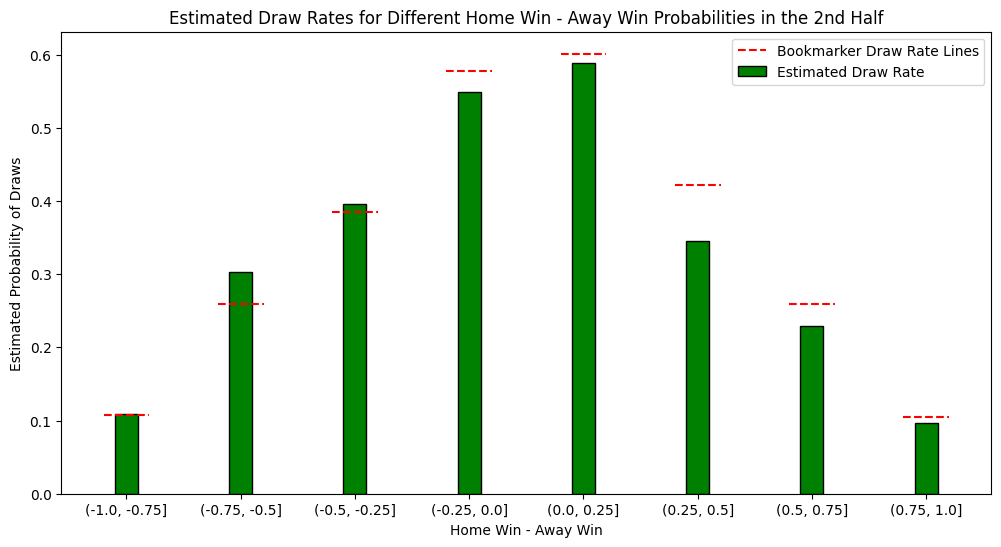

In [657]:
second_half_prob_df = prob_df[prob_df["Half"] == "2nd-half"] # filter the data for the second half

bin_totals = second_half_prob_df.groupby("Bin", observed=False).size() # calculate the total number of games in each bin
bin_draws = second_half_prob_df[second_half_prob_df["Result"] == "X"].groupby("Bin", observed=False).size() # calculate the number of draws in each bin

estimated_draws = bin_draws / bin_totals # calculate the estimated draw probabilities for each bin

bookmarker_draws = second_half_prob_df.groupby("Bin", observed=False)["Pr{Draw}"].mean() # calculate the average bookmarker draw probabilities for each bin

plt.figure(figsize=(12, 6))

plt.bar(bin_totals.index.astype(str), estimated_draws , width=0.2, align="center", edgecolor = "black", color = "green", label="Estimated Draw Rate")
plt.hlines(
    y=bookmarker_draws,                  
    xmin=-0.2 + np.arange(len(bookmarker_draws)),  
    xmax=0.2 + np.arange(len(bookmarker_draws)),  
    colors="red",
    linestyles="--",
    label="Bookmarker Draw Rate Lines")

plt.legend(loc="upper right")
plt.xlabel("Home Win - Away Win")
plt.ylabel("Estimated Probability of Draws")
plt.title("Estimated Draw Rates for Different Home Win - Away Win Probabilities in the 2nd Half")

plt.show()

Still, there are some differences between estimated draw rate and bookmakers' implied probabilities. But they are more closer than the first half data. As discussed before, this was expected.

Now, do the same analysis for the normalized implied probabilities. The results are as follows:

In [658]:
# same bins are used
normalized_prob_df["Pr{Home Win} - Pr{Away Win}"] = normalized_prob_df["Pr{Home Win}"] - normalized_prob_df["Pr{Away Win}"]
normalized_prob_df["Bin"] = pd.cut(normalized_prob_df["Pr{Home Win} - Pr{Away Win}"], bins)

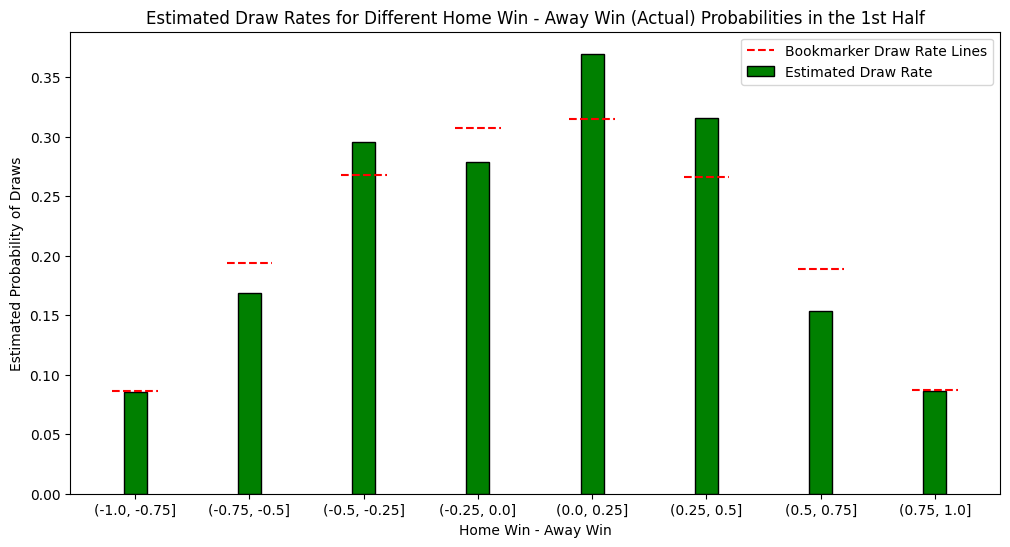

In [659]:
first_half_normalized_prob_df = normalized_prob_df[normalized_prob_df["Half"] == "1st-half"] # filter the data for the first half

bin_totals = first_half_normalized_prob_df.groupby("Bin", observed=False).size() # calculate the total number of games in each bin
bin_draws = first_half_normalized_prob_df[first_half_normalized_prob_df["Result"] == "X"].groupby("Bin", observed=False).size() # calculate the number of draws in each bin

estimated_draws = bin_draws / bin_totals # calculate the estimated draw probabilities for each bin

bookmarker_draws = first_half_normalized_prob_df.groupby("Bin", observed=False)["Pr{Draw}"].mean() # calculate the average bookmarker draw probabilities for each bin

plt.figure(figsize=(12, 6))

plt.bar(bin_totals.index.astype(str), estimated_draws , width=0.2, align="center", edgecolor = "black", color = "green", label="Estimated Draw Rate")
plt.hlines(
    y=bookmarker_draws,                  
    xmin=-0.2 + np.arange(len(bookmarker_draws)),  
    xmax=0.2 + np.arange(len(bookmarker_draws)),  
    colors="red",
    linestyles="--",
    label="Bookmarker Draw Rate Lines")

plt.legend(loc="upper right")
plt.xlabel("Home Win - Away Win")
plt.ylabel("Estimated Probability of Draws")
plt.title("Estimated Draw Rates for Different Home Win - Away Win (Actual) Probabilities in the 1st Half")

plt.show()

Compared to non-normalized implied probabilities, the normalized implied probabilities are more aligned with the actual match outcomes. This is expected, as the normalization process ensures that the probabilities sum up to 1, which can improve the calibration of the odds. However, there are still some discrepancies between the estimated draw rate and the bookmakers' implied probabilities.

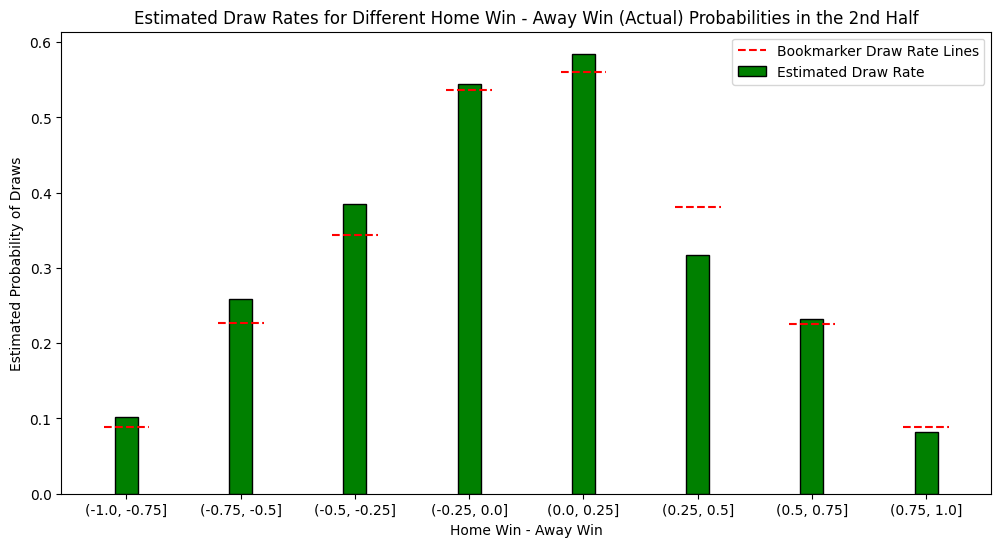

In [660]:
second_half_normalized_prob_df = normalized_prob_df[normalized_prob_df["Half"] == "2nd-half"] # filter the data for the second half

bin_totals = second_half_normalized_prob_df.groupby("Bin", observed=False).size() # calculate the total number of games in each bin
bin_draws = second_half_normalized_prob_df[second_half_normalized_prob_df["Result"] == "X"].groupby("Bin", observed=False).size() # calculate the number of draws in each bin

estimated_draws = bin_draws / bin_totals # calculate the estimated draw probabilities for each bin

bookmarker_draws = second_half_normalized_prob_df.groupby("Bin", observed=False)["Pr{Draw}"].mean() # calculate the average bookmarker draw probabilities for each bin

plt.figure(figsize=(12, 6))

plt.bar(bin_totals.index.astype(str), estimated_draws , width=0.2, align="center", edgecolor = "black", color = "green", label="Estimated Draw Rate")
plt.hlines(
    y=bookmarker_draws,                  
    xmin=-0.2 + np.arange(len(bookmarker_draws)),  
    xmax=0.2 + np.arange(len(bookmarker_draws)),  
    colors="red",
    linestyles="--",
    label="Bookmarker Draw Rate Lines")

plt.legend(loc="upper right")
plt.xlabel("Home Win - Away Win")
plt.ylabel("Estimated Probability of Draws")
plt.title("Estimated Draw Rates for Different Home Win - Away Win (Actual) Probabilities in the 2nd Half")

plt.show()

Except for the (0.25, 0.5] bin, the number of games that ended in a draw appears to closely match the bookmakers' implied probabilities. This indicates that the normalization process successfully improved the alignment between the implied probabilities and the actual match outcomes. However, some discrepancies remain, suggesting room for further refinement.

In the next step of the analysis, we will investigate how removing noisy data impacts the alignment between the implied probabilities and the actual match outcomes. This will help determine whether the discrepancies can be attributed to noise or other underlying factors.

### Noisy Data Analysis <a name="noisy"></a>

In this section, the data that fits any of the following criteria is considered as noisy data and removed from the dataset:

- Goal in the first 10 minutes: The first 10 minutes of a football match can be considered as a period where the teams are still settling into the game. Therefore it may not reflect the expectations for the match.

- Goal after the 80th minute: The final 10 minutes of a football match can be considered as a period where the teams are more likely to play defensively to protect their lead or secure a draw. Therefore, the outcomes in this period may not be representative of the overall match. Also, a goal in this period significantly affect the implied probabilities.

- Red card in first 15 minutes: An early red card can significantly impact the outcome of a football match, as the team with fewer players is at a disadvantage. Therefore, matches with red cards in the first 15 minutes are considered as noisy data.

- Red card after 75 minutes: A red card in the final 15 minutes of a football match can also impact the outcome, as the team with fewer players may struggle to defend or attack effectively. Therefore, matches with red cards after 75 minutes are considered as noisy data.

- Yellow card in first 10 minutes: An early yellow card may not significantly impact the outcome of a football match, but it can be considered as a sign of aggressive play. Therefore It may not reflect expectations for the match. Additionaly, when an important player gets an early yellow card, the player tends to play more cautiously, which may affect the outcome of the match.

- Injuries in the first 30 minutes: An injury in the first 30 minutes of a football match can impact the outcome, as the team may need to make substitutions or adjust their tactics. Therefore, matches with injuries in the first 30 minutes are considered as noisy data.

- Injuries after 75 minutes: An injury in the final 15 minutes of a football match may not significantly impact the outcome, as the match is close to ending. Team may not make a substitution since they may not have any substitution left. Therefore, matches with injuries after 75 minutes are considered as noisy data.

- Substitution in the first 30 minutes: In a football match, a substitution in the first 30 minutes is not common and may indicate an injury or tactical change. Therefore, matches with substitutions in the first 30 minutes are considered as noisy data.

In [661]:
df["Goal_in_first_10_mins"] = df.apply(
    lambda row: True if row["halftime"] == "1st-half" and row["minute"] < 10 and (row["Goals - home"] + row["Goals - away"] >= 1) 
    else False,
    axis=1)

columns_to_keep = ["fixture_id", "halftime", "minute", "Goals - away", "Goals - home"]
matches = df.copy()
matches = matches[columns_to_keep]
matches["Total Goals"] = matches["Goals - away"] + matches["Goals - home"]
matches = matches[(matches["minute"] < 40) & (matches["halftime"] == "2nd-half")]
matches = matches.loc[matches.groupby("fixture_id")["Total Goals"].idxmax()]
matches.drop(columns=["Goals - away", "Goals - home", "halftime", "minute"], inplace=True)
df["Goal_after_80_mins"] = df.apply(
    lambda row: True if row["minute"] >= 40 and row["halftime"] == "2nd-half" and
    (row["Goals - home"] + row["Goals - away"]) > matches[matches["fixture_id"] == row["fixture_id"]]["Total Goals"].values[0] 
    else False,
    axis=1)

df["Redcard_in_first_15_mins"] = df.apply(
    lambda row: True if (row["halftime"] == "1st-half" and row["minute"] < 15) 
    and (row["Redcards - home"] + row["Redcards - away"] + row["Yellowred Cards - home"] + row["Yellowred Cards - away"] >= 1) 
    else False,
    axis=1)

columns_to_keep = ["fixture_id", "halftime", "minute", "Redcards - away", "Redcards - home", "Yellowred Cards - away", "Yellowred Cards - home"]
matches = df.copy()
matches = matches[columns_to_keep]
matches["Total Red Cards"] = matches["Redcards - away"] + matches["Redcards - home"] + matches["Yellowred Cards - away"] + matches["Yellowred Cards - home"]
matches = matches[(matches["minute"] < 35) & (matches["halftime"] == "2nd-half")]
matches = matches.loc[matches.groupby("fixture_id")["Total Red Cards"].idxmax()]
matches.drop(columns=["Redcards - away", "Redcards - home", "Yellowred Cards - away", "Yellowred Cards - home" ,"halftime", "minute"], inplace=True)
df["Red_cards_after_75_mins"] = df.apply(
    lambda row: True if row["minute"] >= 35 and row["halftime"] == "2nd-half" and
    (row["Redcards - home"] + row["Redcards - away"] + row["Yellowred Cards - away"] + row["Yellowred Cards - home"]) > matches[matches["fixture_id"] == row["fixture_id"]]["Total Red Cards"].values[0] 
    else False,
    axis=1)

df["Yellowcard_in_first_10_mins"] = df.apply(
    lambda row: True if row["halftime"] == "1st-half" and row["minute"] < 10 and (row["Yellowcards - home"] + row["Yellowcards - away"] >= 1)
    else False,
    axis=1)

df["Injuries_in_first_30_mins"] = df.apply(
    lambda row: True if (row["halftime"] == "1st-half") and row["minute"] < 30 and (row["Injuries - home"] + row["Injuries - away"] >= 1) 
    else False,
    axis=1)

columns_to_keep = ["fixture_id", "halftime", "minute", "Injuries - away", "Injuries - home"]
matches = df.copy()
matches = matches[columns_to_keep]
matches["Total Injuries"] = matches["Injuries - away"] + matches["Injuries - home"]
matches = matches[(matches["minute"] < 35) & (matches["halftime"] == "2nd-half")]
matches = matches.loc[matches.groupby("fixture_id")["Total Injuries"].idxmax()]
matches.drop(columns=["Injuries - away", "Injuries - home", "halftime", "minute"], inplace=True)
df["Injuries_after_75_mins"] = df.apply(
    lambda row: True if row["minute"] >= 35 and row["halftime"] == "2nd-half" and
    (row["Injuries - home"] + row["Injuries - away"]) > matches[matches["fixture_id"] == row["fixture_id"]]["Total Injuries"].values[0] 
    else False,
    axis=1)

df["Substutions_in_first_30_mins"] = df.apply(
    lambda row: True if row["halftime"] == "1st-half" and row["minute"] < 30 and (row["Substitutions - home"] + row["Substitutions - away"] >= 1) 
    else False,
    axis=1)

In [662]:
print(f"Number of matches with a goal before 10 minutes: {df['Goal_in_first_10_mins'].sum()}")
print(f"Number of matches with a goal after 80 minutes: {df['Goal_after_80_mins'].sum()}")
print(f"Number of matches with a red card before 15 minutes: {df['Redcard_in_first_15_mins'].sum()}")
print(f"Number of matches with a red card after 75 minutes: {df['Red_cards_after_75_mins'].sum()}")
print(f"Number of matches with a yellow card before 10 minutes: {df['Yellowcard_in_first_10_mins'].sum()}")
print(f"Number of matches with an injury before 30 minutes: {df['Injuries_in_first_30_mins'].sum()}")
print(f"Number of matches with an injury after 75 minutes: {df['Injuries_after_75_mins'].sum()}")
print(f"Number of matches with a substitutions before 30 minutes: {df['Substutions_in_first_30_mins'].sum()}")

Number of matches with a goal before 10 minutes: 512
Number of matches with a goal after 80 minutes: 576
Number of matches with a red card before 15 minutes: 11
Number of matches with a red card after 75 minutes: 306
Number of matches with a yellow card before 10 minutes: 196
Number of matches with an injury before 30 minutes: 490
Number of matches with an injury after 75 minutes: 500
Number of matches with a substitutions before 30 minutes: 784


Observe above to see the amount of instantes that fits the given criteria.

In [663]:
print(f"Current number of rows: {len(df)}")
a = len(df)

columns_to_check = [
    "Goal_in_first_10_mins",
    "Redcard_in_first_15_mins",
    "Yellowcard_in_first_10_mins",
    "Injuries_in_first_30_mins",
    "Goal_after_80_mins",
    "Substutions_in_first_30_mins",
    "Red_cards_after_75_mins",
    "Injuries_after_75_mins"
]

mask = (df[columns_to_check] == False).all(axis=1)

df = df[mask]

df = df.drop(columns=columns_to_check)

print(f"Number of rows after removing matches with events: {len(df)}")
print(f"Difference in number of rows: {a - len(df)}")

Current number of rows: 56127
Number of rows after removing matches with events: 52998
Difference in number of rows: 3129


In total, 3129 rows are dropped to make normalized implied probabilities more closer to the actual match outcomes. This amount corresponds to 5.7% of the data. This is not a significant amount of data, but it may to improve the accuracy of the model significantly.

Now, let's us went through the same process to see if the removal of noisy data improved the alignment between the normalized implied probabilities and the actual match outcomes. The results are as follows:

In [664]:
df_odds = df.copy()
results = df_odds['result']
half = df_odds['halftime']
df_odds = df_odds.loc[:, "1":"X"]

prob_df = 1 / df_odds
prob_df.columns = ["Pr{Home Win}", "Pr{Away Win}", "Pr{Draw}"]

normalized_prob_df = prob_df.div(prob_df.sum(axis=1), axis=0)

prob_df["Result"] = results
prob_df["Half"] = half
normalized_prob_df["Result"] = results
normalized_prob_df["Half"] = half

In [665]:
prob_df["Pr{Home Win} - Pr{Away Win}"] = prob_df["Pr{Home Win}"] - prob_df["Pr{Away Win}"]
prob_df["Bin"] = pd.cut(prob_df["Pr{Home Win} - Pr{Away Win}"], bins)

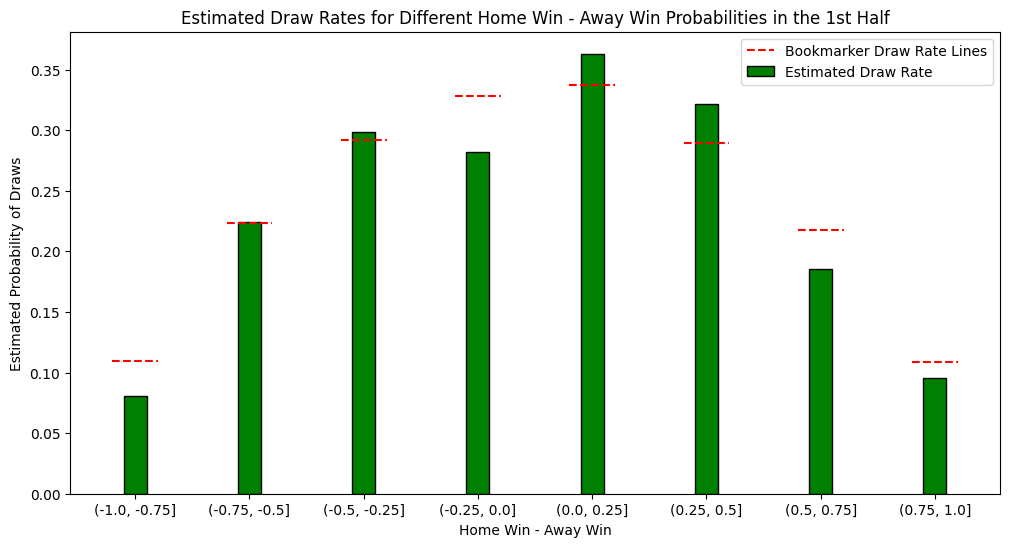

In [666]:
first_half_prob_df = prob_df[prob_df["Half"] == "1st-half"]

bin_totals = first_half_prob_df.groupby("Bin", observed=False).size()
bin_draws = first_half_prob_df[first_half_prob_df["Result"] == "X"].groupby("Bin", observed=False).size()

estimated_draws = bin_draws / bin_totals

bookmarker_draws = first_half_prob_df.groupby("Bin", observed=False)["Pr{Draw}"].mean()

plt.figure(figsize=(12, 6))

plt.bar(bin_totals.index.astype(str), estimated_draws , width=0.2, align="center", edgecolor = "black", color = "green", label="Estimated Draw Rate")
plt.hlines(
    y=bookmarker_draws,                  
    xmin=-0.2 + np.arange(len(bookmarker_draws)),  
    xmax=0.2 + np.arange(len(bookmarker_draws)),  
    colors="red",
    linestyles="--",
    label="Bookmarker Draw Rate Lines")

plt.legend(loc="upper right")
plt.xlabel("Home Win - Away Win")
plt.ylabel("Estimated Probability of Draws")
plt.title("Estimated Draw Rates for Different Home Win - Away Win Probabilities in the 1st Half")

plt.show()

Compared to the previous analysis, the removal of noisy data hasn't seem to improve the alignment between the not normalized implied probabilities and the actual match outcomes.

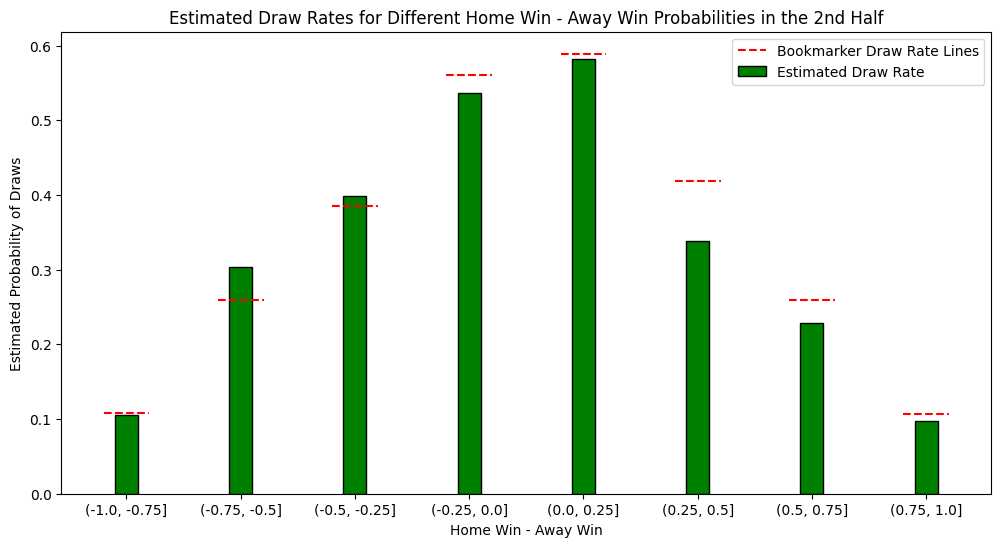

In [667]:
second_half_prob_df = prob_df[prob_df["Half"] == "2nd-half"]

bin_totals = second_half_prob_df.groupby("Bin", observed=False).size()
bin_draws = second_half_prob_df[second_half_prob_df["Result"] == "X"].groupby("Bin", observed=False).size()

estimated_draws = bin_draws / bin_totals

bookmarker_draws = second_half_prob_df.groupby("Bin", observed=False)["Pr{Draw}"].mean()

plt.figure(figsize=(12, 6))

plt.bar(bin_totals.index.astype(str), estimated_draws , width=0.2, align="center", edgecolor = "black", color = "green", label="Estimated Draw Rate")
plt.hlines(
    y=bookmarker_draws,                  
    xmin=-0.2 + np.arange(len(bookmarker_draws)),  
    xmax=0.2 + np.arange(len(bookmarker_draws)),  
    colors="red",
    linestyles="--",
    label="Bookmarker Draw Rate Lines")

plt.legend(loc="upper right")
plt.xlabel("Home Win - Away Win")
plt.ylabel("Estimated Probability of Draws")
plt.title("Estimated Draw Rates for Different Home Win - Away Win Probabilities in the 2nd Half")

plt.show()

Compared to the previous analysis, the removal of noisy data has improved the alignment between the non-normalized implied probabilities and the actual match outcomes in the 2nd half. This improvement is expected, as eliminating noisy data reduces the influence of factors that could introduce bias or distortion into the analysis.

However, since the data is not normalized in this case, certain instances may still fail to accurately reflect the actual match outcomes. To address this, we will re-examine the normalized implied probabilities to evaluate their alignment with the match results after noise removal.

In [668]:
normalized_prob_df["Pr{Home Win} - Pr{Away Win}"] = normalized_prob_df["Pr{Home Win}"] - normalized_prob_df["Pr{Away Win}"]
normalized_prob_df["Bin"] = pd.cut(normalized_prob_df["Pr{Home Win} - Pr{Away Win}"], bins)

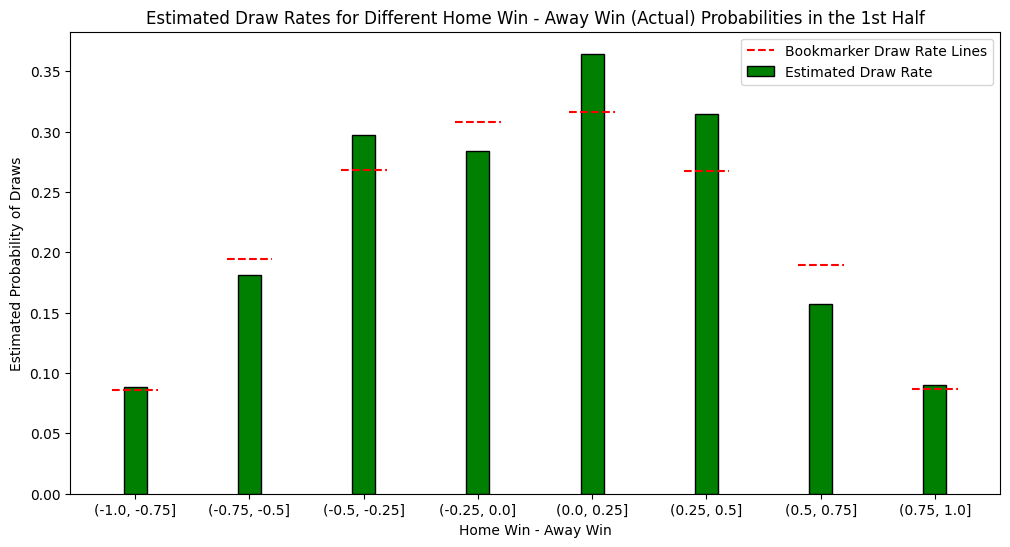

In [669]:
first_half_normalized_prob_df = normalized_prob_df[normalized_prob_df["Half"] == "1st-half"]

bin_totals = first_half_normalized_prob_df.groupby("Bin", observed=False).size()
bin_draws = first_half_normalized_prob_df[first_half_normalized_prob_df["Result"] == "X"].groupby("Bin", observed=False).size()

estimated_draws = bin_draws / bin_totals

bookmarker_draws = first_half_normalized_prob_df.groupby("Bin", observed=False)["Pr{Draw}"].mean()

plt.figure(figsize=(12, 6))

plt.bar(bin_totals.index.astype(str), estimated_draws , width=0.2, align="center", edgecolor = "black", color = "green", label="Estimated Draw Rate")
plt.hlines(
    y=bookmarker_draws,                  
    xmin=-0.2 + np.arange(len(bookmarker_draws)),  
    xmax=0.2 + np.arange(len(bookmarker_draws)),  
    colors="red",
    linestyles="--",
    label="Bookmarker Draw Rate Lines")

plt.legend(loc="upper right")
plt.xlabel("Home Win - Away Win")
plt.ylabel("Estimated Probability of Draws")
plt.title("Estimated Draw Rates for Different Home Win - Away Win (Actual) Probabilities in the 1st Half")

plt.show()

Compared to previous analysis, besides (-0.5, -0.25] and (0.0, 0.25] bins, the removal of the noisy data improved the alignment between the normalized implied probabilities and the actual match outcomes. This improvement is expected, as the elimination of noisy data reduces the impact of factors that could introduce bias or distortion into the analysis. 

In the second half analysis, we should expect the results to be more accurate since the second half of the game is more closer to the final result. As it is obsverved before. The results are as follows:

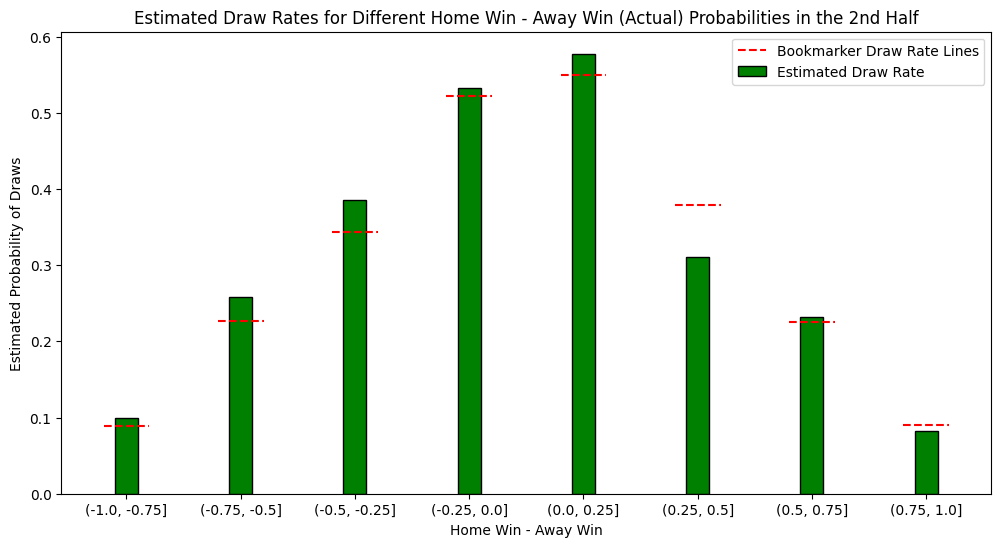

In [670]:
second_half_normalized_prob_df = normalized_prob_df[normalized_prob_df["Half"] == "2nd-half"]

bin_totals = second_half_normalized_prob_df.groupby("Bin", observed=False).size()
bin_draws = second_half_normalized_prob_df[second_half_normalized_prob_df["Result"] == "X"].groupby("Bin", observed=False).size()

estimated_draws = bin_draws / bin_totals

bookmarker_draws = second_half_normalized_prob_df.groupby("Bin", observed=False)["Pr{Draw}"].mean()

plt.figure(figsize=(12, 6))

plt.bar(bin_totals.index.astype(str), estimated_draws , width=0.2, align="center", edgecolor = "black", color = "green", label="Estimated Draw Rate")
plt.hlines(
    y=bookmarker_draws,                  
    xmin=-0.2 + np.arange(len(bookmarker_draws)),  
    xmax=0.2 + np.arange(len(bookmarker_draws)),  
    colors="red",
    linestyles="--",
    label="Bookmarker Draw Rate Lines")

plt.legend(loc="upper right")
plt.xlabel("Home Win - Away Win")
plt.ylabel("Estimated Probability of Draws")
plt.title("Estimated Draw Rates for Different Home Win - Away Win (Actual) Probabilities in the 2nd Half")

plt.show()

Results alligned with the previous analysis. The removal of the noisy data improved the alignment between the normalized implied probabilities and the actual match outcomes. This improvement is expected, as the elimination of noisy data reduces the impact of factors that could introduce bias or distortion into the analysis. However note that change in alignment is not significant. It is probably related to our criteria for noisy data. Most of the criteria are related to the first half of the game. To improve this, more criteria related to the second half of the game can be considered as a further study.

### Decision Tree Model <a name="tree"></a>

In the decision tree model, the goal is to see which features are more important in predicting the outcome of the match. The model is trained on the whole dataset therefore testing/comparing process is not performed. 

Match results are encoded to perform the model. The encoding is as follows:
- 0: Draw
- 1: Home team wins
- 2: Away team wins

In [671]:
target = [1 if result == "1" else 2 if result == "2" else 0 for result in df["result"]] # target is encoded as 1 for home win, 2 for away win, and 0 for draw

Irrelevant columns are removed from the dataset, leaving only the essential features required for training the model. The remaining columns used in the model are displayed in the code below. A brief explanation is as follows:

- "Penalties - home", "Penalties - away", "Assists - home" and "Assists - away" columns are removed since they are included in the goal columns. They are removed to prevent multicolinerity. Decision trees are not sensitive to multicollinearity but it is better to remove them to prevent any possible issues.

- "fixture_id", "current_time", "half_start_datetime", "match_start_datetime", "latest_bookmaker_update", "suspended", "stopped", "name", "second", "ticking" are removed since they are not related to the match outcomes.

- "result", ""1", "2", "X", "final_score" are removed since they are the target variable or related to the target variable.

Additionaly, simply manipulations are performed on the data to make it more suitable for the model. Brief explanation of some key columns is as follows:

- Categorical columns are encoded.

- "Total Goals" column is created by summing the goals of the home and away teams. Since the model may understand the outcome of the match better by looking at the total goals. Ex/ Total Goals = 0 indicates a draw.

- "Goal Diffirence" column is created by subtracting the goals of the away team from the goals of the home team. Since the model may understand the outcome of the match better by looking at the goal diffirence. Ex/ Goal Diffirence = -1 may indicate that the away team wins even if it is an early stage of the game.

- "Dangerous Attacks Difference" column is created by subtracting the dangerous attacks of the away team from the dangerous attacks of the home team. Since the model may understand the outcome of the match better by looking at the dangerous attacks diffirence. 

- "Ball Possession % Difference" column is created by subtracting the ball possession % of the away team from the ball possession % of the home team. Since the model may understand the outcome of the match better by looking at the ball possession % diffirence.

- "Goal Attempts Difference" column is created by subtracting the goal attempts of the away team from the goal attempts of the home team. Since the model may understand the outcome of the match better by looking at the goal attempts diffirence.

In [672]:
feature_df = df.copy()

# drop columns
feature_df.drop(columns=["result", "fixture_id", "current_time", "half_start_datetime", "match_start_datetime", "latest_bookmaker_update", 
                        "suspended", "stopped", "1", "2", "X", "final_score", "Assists - away", "Assists - home", "name", "second", "ticking",
                        "Penalties - home", "Penalties - away"], inplace=True)

feature_df["minute"] = feature_df["minute"].astype(float)
feature_df["halftime"] = [1.0 if half == "1st-half" else 2.0 for half in feature_df["halftime"]]
feature_df["current_state"] = [1.0 if result == "1" else 2.0 if result == "2" else 0 for result in feature_df["current_state"]]
feature_df["Total Goals"] = feature_df["Goals - away"] + feature_df["Goals - home"]
feature_df["Goal Difference"] = feature_df["Goals - home"] - feature_df["Goals - away"]
feature_df["Dangerous Attacks Difference"] = feature_df["Dangerous Attacks - home"] - feature_df["Dangerous Attacks - away"]
feature_df["Ball Possession % Difference"] = feature_df["Ball Possession % - home"] - feature_df["Ball Possession % - away"]
feature_df["Goal Attempts Difference"] = feature_df["Goal Attempts - home"] - feature_df["Goal Attempts - away"]

feature_df

,halftime,minute,Accurate Crosses - away,Accurate Crosses - home,Attacks - away,Attacks - home,Ball Possession % - away,Ball Possession % - home,Ball Safe - away,Ball Safe - home,...,Yellowcards - away,Yellowcards - home,Yellowred Cards - away,Yellowred Cards - home,current_state,Total Goals,Goal Difference,Dangerous Attacks Difference,Ball Possession % Difference,Goal Attempts Difference
0,1.0,9.0,0.0,0.0,2.0,18.0,28.0,72.0,9.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,44.0,0.0
1,1.0,25.0,0.0,1.0,12.0,40.0,24.0,76.0,9.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,52.0,0.0
2,1.0,26.0,0.0,1.0,12.0,40.0,21.0,79.0,9.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,58.0,0.0
3,1.0,27.0,0.0,1.0,12.0,42.0,22.0,78.0,9.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,56.0,0.0
8,1.0,32.0,0.0,1.0,15.0,46.0,21.0,79.0,9.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,58.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63937,2.0,44.0,4.0,3.0,107.0,73.0,68.0,32.0,66.0,52.0,...,1.0,3.0,0.0,0.0,1.0,1.0,1.0,-12.0,-36.0,6.0
63938,2.0,45.0,4.0,3.0,109.0,73.0,68.0,32.0,66.0,52.0,...,1.0,3.0,0.0,0.0,1.0,1.0,1.0,-12.0,-36.0,6.0
63939,2.0,46.0,4.0,3.0,112.0,73.0,68.0,32.0,66.0,52.0,...,1.0,3.0,0.0,0.0,1.0,1.0,1.0,-15.0,-36.0,6.0
63940,2.0,47.0,4.0,3.0,118.0,73.0,68.0,32.0,66.0,52.0,...,1.0,3.0,0.0,0.0,1.0,1.0,1.0,-15.0,-36.0,6.0


The size of the decision tree is constrained using the following parameters to improve interpretability and allow for visual inspection:

- min_impurity_decrease: Ensures splits only occur if the impurity reduction is at least the specified value.

- max_depth: Limits the depth of the tree.

- max leaf nodes: Limits the number of leaf nodes.

Also, note that these parameters are selected by trial and error. They may not be the optimal parameters for the model. 

As a further observation, limiting the depth of the tree and the number of leaf nodes can help prevent overfitting and improve the generalization of the model. This is important to ensure that the model can accurately predict match outcomes based on the available features.

In [673]:
classifier = DecisionTreeClassifier(min_impurity_decrease=1e-5, max_depth=10, max_leaf_nodes=15)

classifier.fit(feature_df, target)

DecisionTreeClassifier(max_depth=10, max_leaf_nodes=15,
                       min_impurity_decrease=1e-05)

In [674]:
predictions = classifier.predict(feature_df)

accuracy = accuracy_score(target, predictions)

correct_guesses = int(len(target) * accuracy)

print(f"Accuracy: {accuracy}")
print(f"Correct Guesses: {correct_guesses}")
print(f"Wrong Guesses: {len(target) - correct_guesses}")

Accuracy: 0.6146269670553606
Correct Guesses: 32574
Wrong Guesses: 20424


As can be seen limiting tree caused not having a high accuracy. But the model is more interpretable which is more important as the time being. The model can be improved by tuning the parameters or using different models.

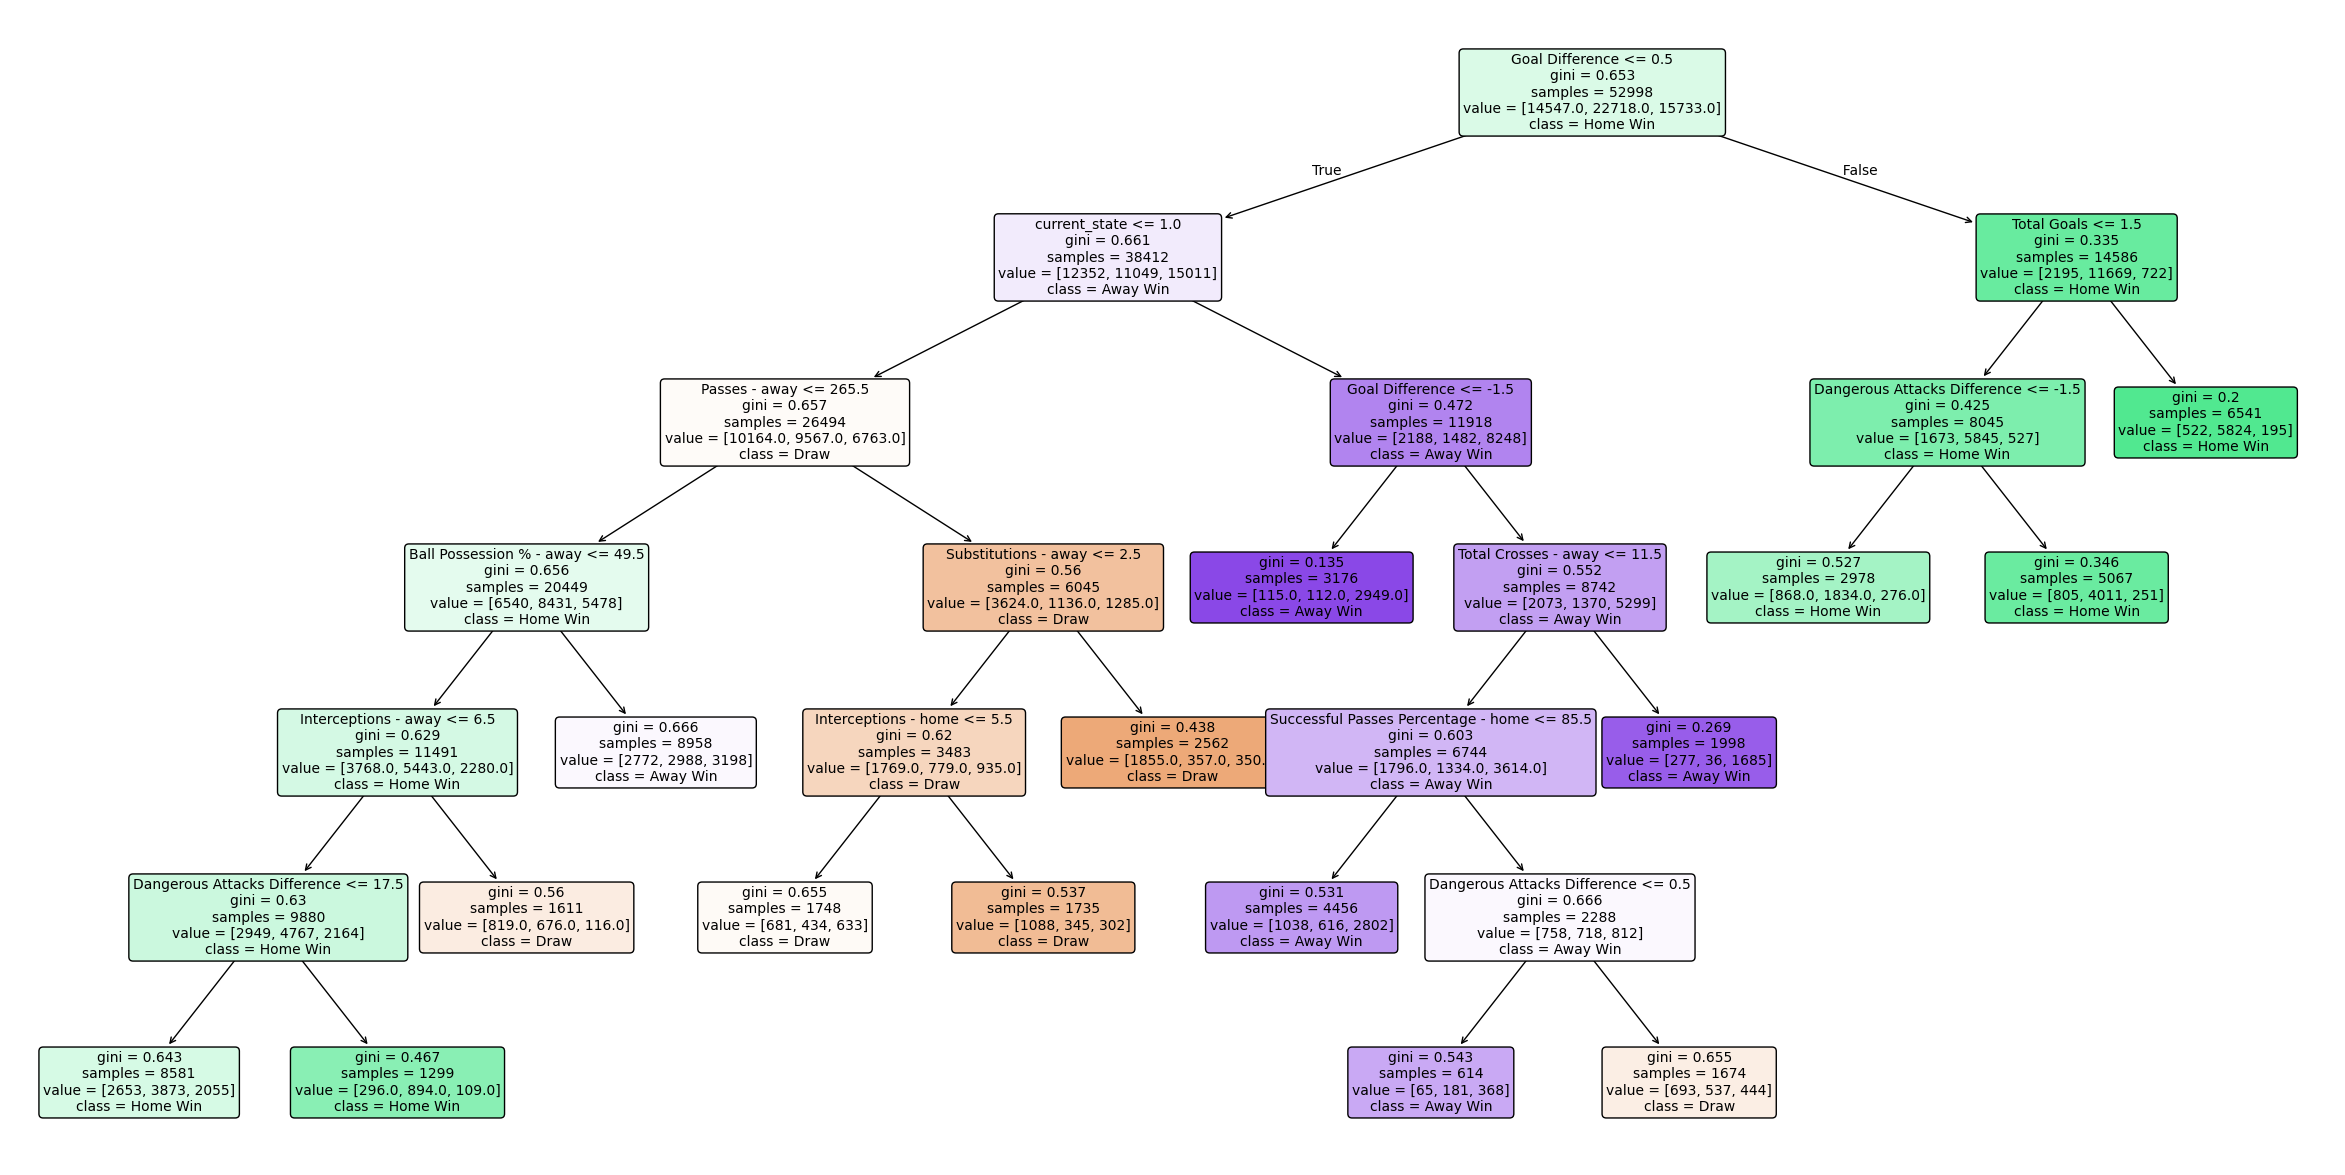

In [ ]:
plt.figure(figsize=(30, 15))  

plot_tree(
    classifier,
    feature_names=feature_df.columns,
    class_names=["Draw","Home Win", "Away Win"], # decode the target values
    filled=True,
    fontsize=10,  
    rounded=True)

plt.show()

Decision tree found following parameters as the most important in predicting the outcome of the match with the chosen parameters:

In [ ]:
print("Feature Importances:")

for feature, importance in zip(feature_df.columns, classifier.feature_importances_):
    if importance > 0:
        print(f"{feature}: {importance:.5f}") 

Feature Importances:
Ball Possession % - away: 0.02521
Interceptions - away: 0.01070
Interceptions - home: 0.00910
Passes - away: 0.06815
Substitutions - away: 0.01167
Successful Passes Percentage - home: 0.01938
Total Crosses - away: 0.02449
current_state: 0.26168
Total Goals: 0.01783
Goal Difference: 0.52009
Dangerous Attacks Difference: 0.03169


This feature selection indicates that the most important features that help the predict of an outcame of the match are related to "control" of the game. Besides "Substitutions - away" which is a bit surprising, all other features are related to the control of the game. This is expected since the team that controls the game is more likely to win the match. Also, dropping "current state" may be a good idea since it came out as an important feature. It may create bias in the model. This is a further study that can be done.

As the final analysis let us compare the results of the decision tree model with the normalized implied probabilities. The results are as follows:

In [ ]:
predict_probs = classifier.predict_proba(feature_df) # predict the probabilities of each class

predicted_prob_df = pd.DataFrame(
    predict_probs, 
    columns=["Pred{Draw}", "Pred{Home Win}", "Pred{Away Win}"])

df_odds = df[["X", "1", "2"]].copy()
prob_df = 1 / df_odds
prob_df.columns = ["Pr{Draw}", "Pr{Home Win}", "Pr{Away Win}"]
normalized_prob_df = prob_df.div(prob_df.sum(axis=1), axis=0)

compare_df = pd.concat([normalized_prob_df.reset_index(drop=True), predicted_prob_df.reset_index(drop=True)], axis=1) # combine the predicted and actual probabilities

# take the difference between the predicted and implied probabilities
compare_df["Diff{Draw}"] = compare_df["Pred{Draw}"] - compare_df["Pr{Draw}"]
compare_df["Diff{Home Win}"] = compare_df["Pred{Home Win}"] - compare_df["Pr{Home Win}"]
compare_df["Diff{Away Win}"] = compare_df["Pred{Away Win}"] - compare_df["Pr{Away Win}"]

compare_df

,Pr{Draw},Pr{Home Win},Pr{Away Win},Pred{Draw},Pred{Home Win},Pred{Away Win},Diff{Draw},Diff{Home Win},Diff{Away Win}
0,0.143310,0.763538,0.093152,0.309171,0.451346,0.239483,0.165861,-0.312192,0.146331
1,0.154762,0.773810,0.071429,0.227868,0.688222,0.083911,0.073106,-0.085588,0.012482
2,0.154762,0.773810,0.071429,0.227868,0.688222,0.083911,0.073106,-0.085588,0.012482
3,0.154762,0.773810,0.071429,0.227868,0.688222,0.083911,0.073106,-0.085588,0.012482
4,0.156250,0.781250,0.062500,0.227868,0.688222,0.083911,0.071618,-0.093028,0.021411
...,...,...,...,...,...,...,...,...,...
52993,0.124938,0.867625,0.007437,0.291471,0.615850,0.092680,0.166533,-0.251776,0.085243
52994,0.086805,0.909390,0.003804,0.291471,0.615850,0.092680,0.204665,-0.293541,0.088875
52995,0.086723,0.908531,0.004746,0.291471,0.615850,0.092680,0.204747,-0.292681,0.087934
52996,0.073871,0.923393,0.002736,0.291471,0.615850,0.092680,0.217599,-0.307543,0.089944


The plot below shows the distribution of the implied match outcomes and the predicted outcomes by the decision tree model. The data is splitted into three groups based on the outcome. For each group, the distribution of the differences between the implied probabilities and the predicted probabilities is displayed.

They all seem to follow a normal distribution. The mean of the differences is close to zero which indicates that the implied probabilities are actually close to the predicted probabilities. This indicates market being efficient. However this result is dependent on the model. If we consider the same question from the other side, it indicates model is not biased which is a good sign for the further studies in the project.

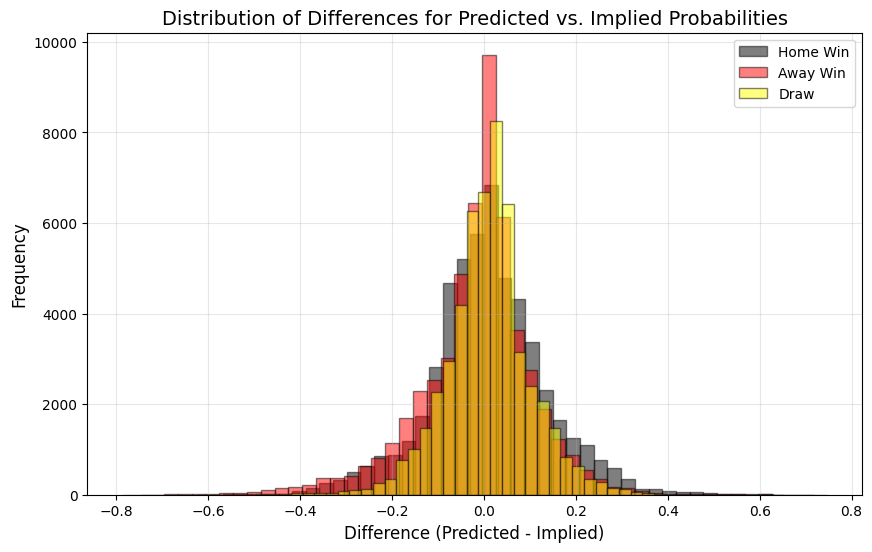

In [678]:
plt.figure(figsize=(10, 6))

compare_df["Diff{Home Win}"].hist(bins=50, alpha=0.5, color='black', edgecolor='black', label="Home Win")
compare_df["Diff{Away Win}"].hist(bins=50, alpha=0.5, color='red', edgecolor='black', label="Away Win")
compare_df["Diff{Draw}"].hist(bins=50, alpha=0.5, color='yellow', edgecolor='black', label="Draw")

plt.title("Distribution of Differences for Predicted vs. Implied Probabilities", fontsize=14)
plt.xlabel("Difference (Predicted - Implied)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.grid(alpha=0.3)
plt.legend(loc = "upper right")
plt.show()

### Conclusion <a name="conclusion"></a>

This homework assignment investigated the application of statistical and basic machine learning techniques in sports betting, specifically focusing on predicting football match outcomes. The analysis included calculating implied probabilities from betting odds, cleaning the dataset by removing noisy events, and comparing the implied probabilities with predictions generated by a decision tree model.

A key objective at each stage was to evaluate the alignment between the implied probabilities and actual match outcomes. The findings revealed that the implied probabilities were not perfectly calibrated, as they occasionally diverged from the actual results. However, normalizing the implied probabilities and removing noisy data reduced these discrepancies, leading to a more accurate representation.

The decision tree model was employed to identify the most influential features for predicting match outcomes. The model highlighted parameters closely related to game control as the most significant predictors. Finally, the model's predictions were compared with the normalized implied probabilities. The minimal differences between the two suggested that the model was unbiased and capable of producing reliable results.


### Code <a name="code"></a>

Click [here](https://github.com/BU-IE-582/fall-24-lmfaraday/blob/main/Homework%202/code.ipynb) to access the code.

---


AI usage in this homework assignment:

- Apple Intelligence is utilized to check the grammar of the text.
- Throughout the code, GitHub Copilot is employed to enhance coding efficiency.